In [2]:
import pylab as pl
import pandas as pd
import numpy as np
import glob
#imports downloader

import scipy.stats
%pylab inline
import urllib
import requests
import os
import sys
#this makes my plots pretty! but it is totally not mandatory to do it
import json
os.environ["PUI2018"] = "%s/PUI2018"%os.getenv("HOME")
os.environ["PUIDATA"] = "%s/PUIdata"%os.getenv("HOME")
if os.getenv ('PUI2018') is None:
    print ("Must set env variable PUI2018")
if os.getenv ('PUIDATA') is None:
    print ("Must set env variable PUI2018")
print(os.getenv("PUIDATA"))
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point
import shapely
from fiona.crs import from_epsg
from geopandas.tools import sjoin

Populating the interactive namespace from numpy and matplotlib
/nfshome/vvt221/PUIdata


# Get the data

In [5]:
def getCitiBikeCSV(datestring):
    print ("Downloading", datestring)
    ### First I will heck that it is not already there
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        if os.path.isfile(datestring + "-citibike-tripdata.csv"):
            # if in the current dir just move it
            if os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA")):
                print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
        else:
            if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip"):
                if not os.path.isfile(datestring + "-citibike-tripdata.csv.zip"):
                    os.system("curl -O https://s3.amazonaws.com/tripdata/JC-" + datestring + "-citibike-tripdata.csvzip")
                ###  To move it I use the os.system() functions to run bash commands with arguments
                os.system("mv " + datestring + "-citibike-tripdata.zip " + os.getenv("PUIDATA"))
            ### unzip the csv 
            os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            if '2014' in datestring:
                os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          "\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
            os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
    if not os.path.isfile(os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.csv"):
        print ("WARNING!!! something is wrong: the file is not there!")

    else:
        print ("file in place, you can continue")

In [6]:

for i in range(1,10):
    if i < 10 :
        date = '20160' + str(i)
    else:
        date = '2016' + str(i)
    
    getCitiBikeCSV(date)

file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue
file in place, you can continue


In [7]:
# Download Puma shape file
url = 'https://data.cityofnewyork.us/api/geospatial/cwiz-gcty?method=export&format=Shapefile'
urllib.request.urlretrieve(url, "puma.gz")
os.system("unzip " "puma.zip" + " -d " + os.getenv('PUIDATA') + '/puma')
for filename in os.listdir(os.getenv('PUIDATA') + '/puma'):
    if filename.endswith('.shp'):
        os.rename(os.getenv('PUIDATA') + '/puma/' + filename, os.getenv('PUIDATA') + '/puma/' + 'puma.shp')

In [3]:
citibike_df = pd.concat([pd.read_csv(f) for f in glob.glob(os.getenv('PUIDATA')+ '/20160*-citibike-tripdata.csv')])


In [3]:
url = 'https://data.cityofnewyork.us/api/views/8fje-7v4x/files/2a7e053b-2ebf-43d5-be55-e42e8754c7c8?filename=ACS5yrPUMA.zip'
urllib.request.urlretrieve(url, "puma2016_rr.gz")

!unzip -d $PUIDATA puma2016.gz

Archive:  puma2016.gz
  inflating: /nfshome/vvt221/PUIdata/demo_2016acs5yr_puma.xlsx  
  inflating: /nfshome/vvt221/PUIdata/econ_2016acs5yr_puma.xlsx  
  inflating: /nfshome/vvt221/PUIdata/hous_2016acs5yr_puma.xlsx  
  inflating: /nfshome/vvt221/PUIdata/soc_2016acs5yr_puma.xlsx  


In [5]:

citibike_df.rename(columns={'Trip Duration' : 'tripduration', 
                              'Start Time' : 'starttime', 'Stop Time' : 'stoptime', 'Start Station ID' :'start station id',
       'Start Station Name': 'start station name' , 'Start Station Latitude' : 'start station latitude',
       'Start Station Longitude' : 'start station longitude' , 'End Station ID' : 'end station id' , 'End Station Name' : 'end station name',
       'End Station Latitude': 'end station latitude' , 'End Station Longitude' : 'end station longitude', 'Bike ID' : 'bikeid' , 'User Type': 'usertype',
       'Birth Year': 'birth year', 'Gender' : 'gender'}, inplace = True)

In [6]:
citibike_df.dropna(inplace=True)

In [7]:
# load the puma shape file
puma_shape_file = geopandas.GeoDataFrame.from_file('%s/puma/puma.shp'%os.getenv('PUIDATA'))

In [8]:
# read the acs data
# plotting median income of puma and the total ridership of starting station of each puma
acs_econ = pd.read_excel(os.getenv('PUIDATA') +'/econ_2016acs5yr_puma.xlsx',sheet_name='EconData')
acs_econ_df = acs_econ[['GeoID','Borough','MdHHIncE']]
acs_demo = pd.read_excel(os.getenv('PUIDATA') +'/demo_2016acs5yr_puma.xlsx',sheet_name='DemoData')
acs_demo_df = acs_demo[['GeoID','Borough','MdAgeE', 'MaleE', 'FemE' ]]

In [9]:
#calculate the female to male ratio
acs_demo_df.FemE = acs_demo_df.FemE.astype(int) 
acs_demo_df.MaleE = acs_demo_df.MaleE.astype(int)
acs_demo_df['FM_ratio'] = acs_demo_df['FemE'] / acs_demo_df['MaleE']

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:
acs_demo_df.head()

,GeoID,Borough,MdAgeE,MaleE,FemE,FM_ratio
0,4001,Brooklyn,31.6,78095,79338,1.015917
1,4002,Brooklyn,30.4,67768,68069,1.004442
2,4003,Brooklyn,30.7,67613,75076,1.110378
3,4004,Brooklyn,34.6,64316,71363,1.109568
4,4005,Brooklyn,35.7,55601,60743,1.092480


In [11]:
citibike_df['birth year'] = pd.to_datetime(citibike_df['birth year'] , infer_datetime_format=True)

citibike_df['age'] = 2016 - citibike_df['birth year'].astype(int)

In [12]:
# aggregate start station id wise count of the ridership in the year 2016
citibike_count_startstation = citibike_df.groupby('start station id')[['tripduration']].agg('count')
citibike_count_startstation.reset_index(inplace=True)

In [13]:
citibike_gender_station = citibike_df.groupby(['start station id','gender'])[['tripduration']].count()
citibike_gender_station.reset_index(inplace=True)

In [14]:
male_counts = citibike_gender_station[citibike_gender_station['gender'] == 1]
male_counts.rename(columns={'tripduration' : 'male_ridership'},inplace=True)

female_counts = citibike_gender_station[citibike_gender_station['gender'] == 2]
female_counts.rename(columns={'tripduration' : 'female_ridership'},inplace = True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/frame.py:2754: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [15]:
mf_ridership = pd.merge(male_counts,female_counts, on='start station id')
mf_ridership['fm_ratio'] = mf_ridership['female_ridership'] / mf_ridership['male_ridership']

In [16]:
citibike_start_station_medianAge = pd.DataFrame(citibike_df.groupby('start station id')['age'].median())

In [17]:
puma_shape_file.puma = puma_shape_file.puma.astype(int)
puma_median_age = puma_shape_file.merge(acs_demo_df,left_on='puma', right_on='GeoID')

In [18]:
puma_median_age_mb = puma_median_age[(puma_median_age['Borough'] == 'Brooklyn')| (puma_median_age['Borough'] == 'Manhattan')]
puma_median_age_mb.head()

,puma,shape_area,shape_leng,geometry,GeoID,Borough,MdAgeE,MaleE,FemE,FM_ratio
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,4015,Brooklyn,34.3,76019,86011,1.131441
5,4016,1.207135e+08,109477.751817,POLYGON ((-73.94405560932151 40.61199284173428...,4016,Brooklyn,39.9,72996,77935,1.067661
9,4006,6.184965e+07,42555.996557,POLYGON ((-73.95526963654763 40.67012490485409...,4006,Brooklyn,34.2,58174,69453,1.193884
13,3801,8.124958e+07,64103.138480,(POLYGON ((-73.92640556921116 40.8776214765373...,3801,Manhattan,35.4,107364,111334,1.036977
14,4011,4.762886e+07,34965.040151,POLYGON ((-73.92828249221591 40.66144706650274...,4011,Brooklyn,34.3,50768,60557,1.192818


In [19]:
puma_demograph = puma_shape_file.merge(acs_econ_df,left_on='puma',right_on='GeoID')
puma_demograph_income = puma_demograph[(puma_demograph['Borough'] == 'Brooklyn')| (puma_demograph['Borough'] == 'Manhattan')]
puma_demograph_income.head()

,puma,shape_area,shape_leng,geometry,GeoID,Borough,MdHHIncE
4,4015,8.105438e+07,50007.415493,POLYGON ((-73.95374853778468 40.63858633758547...,4015,Brooklyn,48169
5,4016,1.207135e+08,109477.751817,POLYGON ((-73.94405560932151 40.61199284173428...,4016,Brooklyn,54475
9,4006,6.184965e+07,42555.996557,POLYGON ((-73.95526963654763 40.67012490485409...,4006,Brooklyn,45503
13,3801,8.124958e+07,64103.138480,(POLYGON ((-73.92640556921116 40.8776214765373...,3801,Manhattan,43307
14,4011,4.762886e+07,34965.040151,POLYGON ((-73.92828249221591 40.66144706650274...,4011,Brooklyn,44329


In [20]:
# extract station id, latitude longitude and index by start station id
station_coordinates_df = citibike_df[['start station id','start station longitude','start station latitude']]
station_coordinates_df.drop_duplicates(inplace=True)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/util/decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [21]:
station_coordinates_df['lonlat'] = list(zip(station_coordinates_df["start station longitude"].values,station_coordinates_df["start station latitude"].values))
station_coordinates_df[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
station_coordinates_df['geometry'] = station_coordinates_df[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [215]:
station_cd = geopandas.GeoDataFrame(station_coordinates_df)

station_cd.crs = from_epsg(4326)

station_cd = station_cd.to_crs(epsg=2263)
puma_demograph_income = puma_demograph_income.to_crs(epsg=2263)

sj = sjoin(station_cd,puma_demograph_income)

puma_demograph_income = puma_demograph_income.to_crs(epsg=4326)
station_cd = station_cd.to_crs(epsg=4326)

In [217]:
sj.head()

,start station id,start station longitude,start station latitude,lonlat,geometry,index_right,puma,shape_area,shape_leng,GeoID,Borough,MdHHIncE
0,536,-73.975361,40.741444,"(-73.97536082, 40.74144387)",POINT (991077.7250432208 209405.5749882631),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171
14,461,-73.982050,40.735877,"(-73.98205027, 40.73587678)",POINT (989224.4375521196 207376.8574359287),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171
27,504,-73.981656,40.732219,"(-73.98165557, 40.73221853)",POINT (989334.1005119402 206044.0648005583),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171
28,528,-73.977061,40.742909,"(-73.97706058, 40.74290902)",POINT (990606.5674025594 209939.2478027958),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171
53,441,-73.967416,40.756014,"(-73.967416, 40.756014)",POINT (993277.3271495601 214714.6604917161),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171


In [218]:
sj = sj.merge(puma_demograph_income,on='puma')

In [219]:
sj.head()

,start station id,start station longitude,start station latitude,lonlat,geometry_x,index_right,puma,shape_area_x,shape_leng_x,GeoID_x,Borough_x,MdHHIncE_x,shape_area_y,shape_leng_y,geometry_y,GeoID_y,Borough_y,MdHHIncE_y
0,536,-73.975361,40.741444,"(-73.97536082, 40.74144387)",POINT (991077.7250432208 209405.5749882631),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616097...,3808,Manhattan,106171
1,461,-73.982050,40.735877,"(-73.98205027, 40.73587678)",POINT (989224.4375521196 207376.8574359287),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616097...,3808,Manhattan,106171
2,504,-73.981656,40.732219,"(-73.98165557, 40.73221853)",POINT (989334.1005119402 206044.0648005583),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616097...,3808,Manhattan,106171
3,528,-73.977061,40.742909,"(-73.97706058, 40.74290902)",POINT (990606.5674025594 209939.2478027958),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616097...,3808,Manhattan,106171
4,441,-73.967416,40.756014,"(-73.967416, 40.756014)",POINT (993277.3271495601 214714.6604917161),23,3808,4.498784e+07,44430.927768,3808,Manhattan,106171,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616097...,3808,Manhattan,106171


In [222]:
sj = geopandas.GeoDataFrame(sj)


In [226]:
sj.rename(columns={'geometry_y': 'geometry' } , inplace=True)


In [234]:
sj.crs

In [202]:
sj = station_cd.to_crs(epsg=4326)

In [203]:
sj.reset_index(inplace=True)

In [231]:
station_cd = geopandas.GeoDataFrame(station_coordinates_df)

station_cd.crs = from_epsg(4326)

station_cd = station_cd.to_crs(epsg=2263)
puma_median_age_mb = puma_median_age_mb.to_crs(epsg=2263)

sj2 = sjoin(station_cd,puma_median_age_mb)

puma_median_age_mb = puma_median_age_mb.to_crs(epsg=4326)
station_cd = station_cd.to_crs(epsg=4326)

In [239]:

sj2 = sj2.merge(puma_median_age_mb,on='puma')
sj2 = geopandas.GeoDataFrame(sj2)
sj.rename(columns={ 'geometry_y': 'geometry' } , inplace=True)
sj2.head()

,start station id,start station longitude,start station latitude,lonlat,geometry_x,index_right,puma,shape_area_x,shape_leng_x,GeoID_x,...,FM_ratio_y,shape_area,shape_leng,geometry,GeoID,Borough,MdAgeE,MaleE,FemE,FM_ratio
0,536,-73.975361,40.741444,"(-73.97536082, 40.74144387)",POINT (991077.7250432208 209405.5749882631),23,3808,4.498784e+07,44430.927768,3808,...,1.222912,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616140...,3808,Manhattan,36.6,66017,80733,1.222912
1,461,-73.982050,40.735877,"(-73.98205027, 40.73587678)",POINT (989224.4375521196 207376.8574359287),23,3808,4.498784e+07,44430.927768,3808,...,1.222912,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616140...,3808,Manhattan,36.6,66017,80733,1.222912
2,504,-73.981656,40.732219,"(-73.98165557, 40.73221853)",POINT (989334.1005119402 206044.0648005583),23,3808,4.498784e+07,44430.927768,3808,...,1.222912,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616140...,3808,Manhattan,36.6,66017,80733,1.222912
3,528,-73.977061,40.742909,"(-73.97706058, 40.74290902)",POINT (990606.5674025594 209939.2478027958),23,3808,4.498784e+07,44430.927768,3808,...,1.222912,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616140...,3808,Manhattan,36.6,66017,80733,1.222912
4,441,-73.967416,40.756014,"(-73.967416, 40.756014)",POINT (993277.3271495601 214714.6604917161),23,3808,4.498784e+07,44430.927768,3808,...,1.222912,4.498784e+07,44430.927768,(POLYGON ((-73.96236596889439 40.7242090616140...,3808,Manhattan,36.6,66017,80733,1.222912


In [196]:

sj.head()

,start station id,start station longitude,start station latitude,lonlat,geometry
index_left,,,,,
0,536,-73.975361,40.741444,"(-73.97536082, 40.74144387)",POINT (-73.97536082000001 40.74144386999984)
1,361,-73.991908,40.716059,"(-73.99190759, 40.71605866)",POINT (-73.99190759000001 40.71605865999985)
2,301,-73.983688,40.722174,"(-73.98368779, 40.72217444)",POINT (-73.98368779 40.72217443999985)
4,492,-73.990931,40.750200,"(-73.99093085, 40.75019995)",POINT (-73.99093085 40.75019994999983)
5,445,-73.981420,40.727408,"(-73.98142006, 40.72740794)",POINT (-73.98142006 40.72740793999984)


In [141]:
citibike_start_station_medianAge.reset_index(inplace=True)

ValueError: cannot insert level_0, already exists

In [123]:
# merge all the citibike dataframes on the start station id index
citibike_vis_df1 = pd.merge(citibike_start_station_medianAge,sj ,on=['start station id'], how='inner')
cb_mfr_vis_df2 = pd.merge(mf_ridership,sj,on=['start station id'], how='inner')
cb_ridership_vis_df = pd.merge(citibike_count_startstation,sj,on=['start station id'], how='inner')

In [124]:
citibike_vis_df = geopandas.GeoDataFrame(citibike_vis_df1)
cb_mfr_vis_df2 = geopandas.GeoDataFrame(cb_mfr_vis_df2)
cb_ridership_vis_df = geopandas.GeoDataFrame(cb_ridership_vis_df)


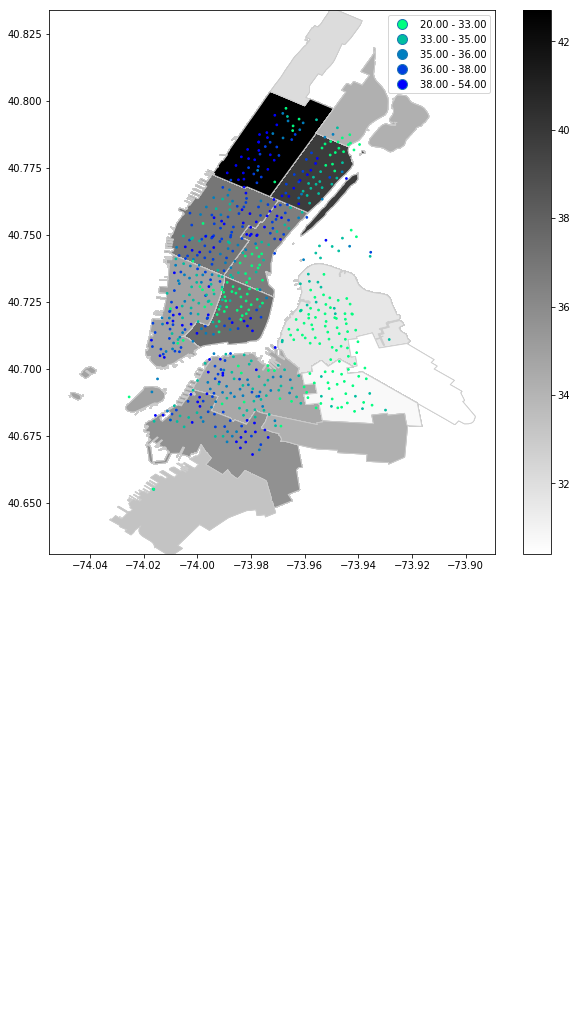

In [241]:
fig  = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#
#puma_shape_file.plot(edgecolor='white',color='grey',ax=ax)
sj2.plot(column='MdAgeE',cmap='gray_r',linewidth=0.8, edgecolor='0.8',ax=ax,legend=True)
#ax.axis('off')
ax2 = ax.twinx()
citibike_vis_df.plot(column='age',legend=True,ax=ax2,scheme = 'Quantiles',cmap='winter_r',markersize=3)
#leg = ax.get_legend()
#leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
ax2.legend(loc=0)
#ax2.set_ylim() = ax.get_ylim()
ax2.axis('off')
y1,y2 = ax.get_ylim()
ax2.set_ylim(ax.get_ylim())
savefig('final1.png')
ax.axes.set_aspect('equal')

### Figure 1: This plot displays the median age of each puma against which the median age of the ridership of  each citibike station is plotted. It appears that  median age at citibike station is correlated with the overall median age at each puma

In [129]:
citibike_vis_df1.head()

,level_0,index,start station id,age,index_right,start station longitude,start station latitude,lonlat,geometry
0,0,0,72,36.0,1064,-73.993929,40.767272,"(-73.99392888, 40.76727216)",POINT (-73.99392888 40.76727215999986)
1,1,1,79,39.0,89,-74.006667,40.719116,"(-74.00666661, 40.71911552)",POINT (-74.00666661 40.71911551999984)
2,2,2,82,42.0,1168,-74.000165,40.711174,"(-74.00016545, 40.71117416)",POINT (-74.00016545 40.71117415999982)
3,3,3,83,34.0,2914,-73.976323,40.683826,"(-73.97632328, 40.68382604)",POINT (-73.97632328 40.68382603999984)
4,4,4,116,36.0,170,-74.001497,40.741776,"(-74.00149746, 40.74177603)",POINT (-74.00149746000001 40.74177602999984)


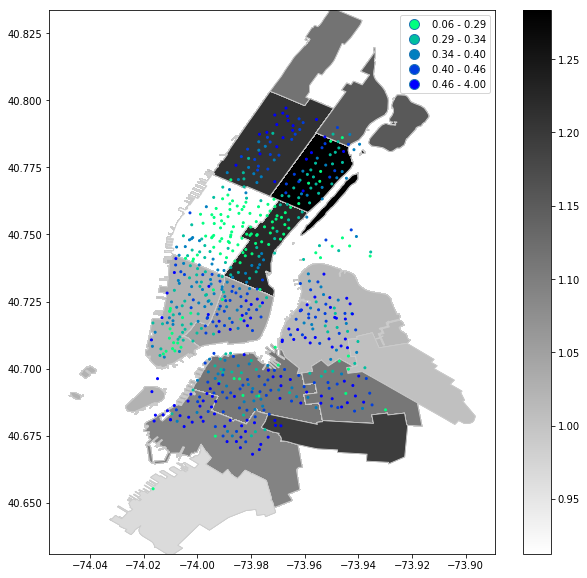

In [240]:
fig  = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

sj2.plot(column='FM_ratio_y',cmap='gray_r',linewidth=0.8, edgecolor='0.8',ax=ax,
                             legend=True )

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

cb_mfr_vis_df2.plot(column='fm_ratio',cmap='winter_r',markersize=4,legend=True,ax=ax2,scheme = 'Quantiles')
ax2.legend(loc=0)
ax2.axis('off')
ax.axes.set_aspect('equal')
savefig('final2.png')

### Figure 2: This plot displays the  female to male  ratio of each puma against which the female to male ridership of each citibike station is plotted. 

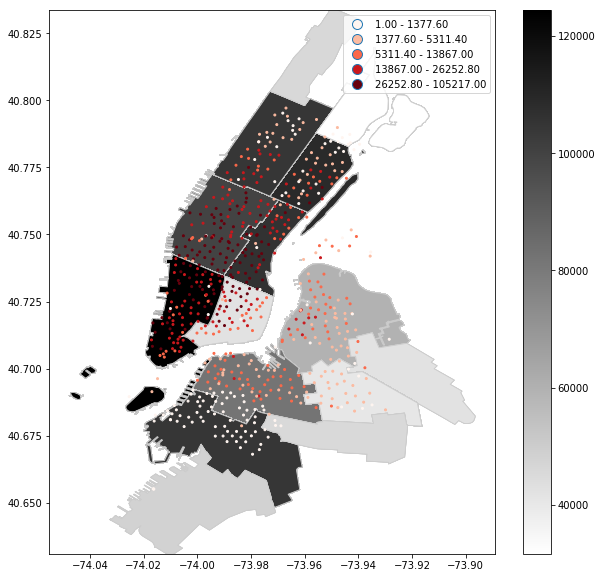

In [230]:
fig  = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

sj.plot(column='MdHHIncE_y',cmap='gray_r',linewidth=0.8, edgecolor='0.8',ax=ax,
                             legend=True )

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

cb_ridership_vis_df.plot(column='tripduration',cmap='Reds',markersize=4,legend=True,ax=ax2,scheme = 'Quantiles')
ax2.legend(loc=0)
ax2.axis('off')
savefig('final3.png')
ax.axes.set_aspect('equal')

### Figure 3: This plot displays the  income of each puma against which the total ridership of each citibike station is plotted. It appears that higher income areas have higher ridership citibike stations.